In [1]:
# Import our dependencies

import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report

#  Import and read the charity_data.csv.

df = pd.read_csv('Resources/cleaned_data.csv', delimiter=',')
df.head()

,id,age_days,age_years,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,50,2,168,62.00,110,80,1,1,0,0,1,0
1,1,20228,55,1,156,85.00,140,90,3,1,0,0,1,1
2,2,18857,52,1,165,64.00,130,70,3,1,0,0,0,1
3,3,17623,48,2,169,82.00,150,100,1,1,0,0,1,1
4,4,17474,48,1,156,56.00,100,60,1,1,0,0,0,0


# Dataset Exploration

In [2]:
df.shape

(70000, 14)

In [3]:
df.dtypes

id               int64
age_days         int64
age_years        int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [4]:
df.describe()

,id,age_days,age_years,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00
mean,49972.42,19468.87,53.30,1.35,164.36,74.21,128.82,96.63,1.37,1.23,0.09,0.05,0.80,0.50
std,28851.30,2467.25,6.76,0.48,8.21,14.40,154.01,188.47,0.68,0.57,0.28,0.23,0.40,0.50
min,0.00,10798.00,30.00,1.00,55.00,10.00,-150.00,-70.00,1.00,1.00,0.00,0.00,0.00,0.00
25%,25006.75,17664.00,48.00,1.00,159.00,65.00,120.00,80.00,1.00,1.00,0.00,0.00,1.00,0.00
50%,50001.50,19703.00,54.00,1.00,165.00,72.00,120.00,80.00,1.00,1.00,0.00,0.00,1.00,0.00
75%,74889.25,21327.00,58.00,2.00,170.00,82.00,140.00,90.00,2.00,1.00,0.00,0.00,1.00,1.00
max,99999.00,23713.00,65.00,2.00,250.00,200.00,16020.00,11000.00,3.00,3.00,1.00,1.00,1.00,1.00


In [5]:
df.cardio.value_counts()

cardio
0    35021
1    34979
Name: count, dtype: int64

# Prep Data for Training

In [6]:
# Caluclate BMI (Body Mass Index)

# Convert height from centimeters to meters
df['height_meters'] = df['height'] / 100

# Calculate BMI (weight in kilograms / (height in meters)^2)
df['bmi'] = df['weight'] / (df['height_meters'] ** 2)

In [7]:
# Split our preprocessed data into our features and target arrays
features = df.drop(columns=['cardio', 'age_years', 'id', 'height_meters'])
X = features.values
y = df['cardio'].values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# LazyPredict

In [9]:
# clf = LazyClassifier(verbose=1,ignore_warnings=False, custom_metric=None)
# models,predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)
# models

# Training the Model

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

model = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.737 (0.004)


In [ ]:
import os
import optuna

# Define the objective function
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'objective': 'binary',
        'metric': 'binary_error'
    }
    
    # Initialize and train the model
    model = LGBMClassifier(**params)
    model.fit(X_train_scaled, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return 1.0 - accuracy  # Optuna minimizes the objective function

# Create Optuna study
storage = f"sqlite:///{os.path.join(os.getcwd(), 'Tuning/optuna_study.db')}"
study = optuna.create_study(direction='minimize', study_name='model_tuning_accuracy', storage=storage)
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_model = LGBMClassifier(**best_params)
best_model.fit(X_train_scaled, y_train)

# Evaluate accuracy on the test set
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [12]:
print(best_params)

{'learning_rate': 0.024797430142409035, 'max_depth': 7, 'num_leaves': 152, 'feature_fraction': 0.7263880488097676, 'subsample': 0.9823925080165798, 'n_estimators': 77}


In [13]:
importances = best_model.feature_importances_
sorted(zip(importances, features.columns), reverse=True)

[(1743, 'age_days'),
 (1644, 'bmi'),
 (1109, 'weight'),
 (865, 'height'),
 (630, 'ap_hi'),
 (588, 'ap_lo'),
 (383, 'cholesterol'),
 (290, 'gluc'),
 (245, 'active'),
 (179, 'gender'),
 (135, 'smoke'),
 (102, 'alco')]

In [14]:
# Normalize feature importances
total_importance = sum(importances)
normalized_importances = importances / total_importance
rounded_importances = np.round(normalized_importances, 3)
sorted(zip(rounded_importances, features.columns), reverse=True)

[(0.22, 'age_days'),
 (0.208, 'bmi'),
 (0.14, 'weight'),
 (0.109, 'height'),
 (0.08, 'ap_hi'),
 (0.074, 'ap_lo'),
 (0.048, 'cholesterol'),
 (0.037, 'gluc'),
 (0.031, 'active'),
 (0.023, 'gender'),
 (0.017, 'smoke'),
 (0.013, 'alco')]

In [15]:
feature_importance_df = pd.DataFrame(rounded_importances, index=features.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importance_df

,importance
age_days,0.22
bmi,0.21
weight,0.14
height,0.11
ap_hi,0.08
ap_lo,0.07
cholesterol,0.05
gluc,0.04
active,0.03
gender,0.02


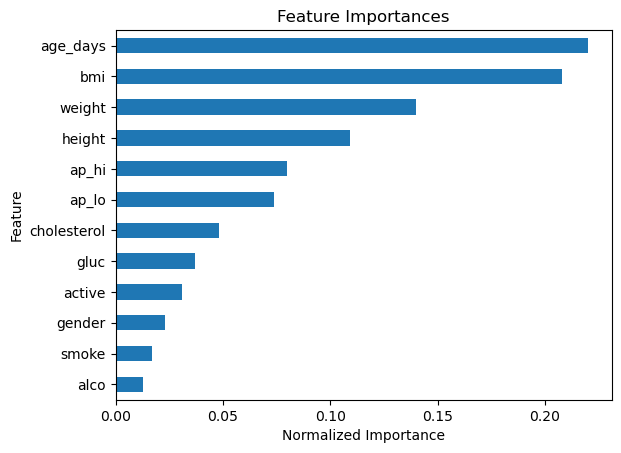

In [16]:
sorted_feature_importance_df = feature_importance_df.sort_values('importance', ascending=True)

# Plot normalized feature importances
sorted_feature_importance_df.plot(kind='barh', legend=False)
plt.title('Feature Importances')
plt.xlabel('Normalized Importance')
plt.ylabel('Feature')
plt.show()

In [17]:
# Print the balanced_accuracy score of the model
print(f'Accuracy score: {balanced_accuracy_score(y_test, y_pred)}')

Accuracy score: 0.7402630474599763


In [18]:
# Generate a confusion matrix for the model
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')

Confusion Matrix: 
[[6824 1864]
 [2687 6125]]


In [19]:
# Print the classification report for the model
cardio_labels = ['low risk', 'high risk']
print(f'Classification Report: \n{classification_report(y_test, y_pred, target_names= cardio_labels)}')

Classification Report: 
              precision    recall  f1-score   support

    low risk       0.72      0.79      0.75      8688
   high risk       0.77      0.70      0.73      8812

    accuracy                           0.74     17500
   macro avg       0.74      0.74      0.74     17500
weighted avg       0.74      0.74      0.74     17500



In [20]:
df.head()

,id,age_days,age_years,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,height_meters,bmi
0,0,18393,50,2,168,62.00,110,80,1,1,0,0,1,0,1.68,21.97
1,1,20228,55,1,156,85.00,140,90,3,1,0,0,1,1,1.56,34.93
2,2,18857,52,1,165,64.00,130,70,3,1,0,0,0,1,1.65,23.51
3,3,17623,48,2,169,82.00,150,100,1,1,0,0,1,1,1.69,28.71
4,4,17474,48,1,156,56.00,100,60,1,1,0,0,0,0,1.56,23.01


In [21]:
med_dict = {'age_days': 18393, 'gender': 2, 'height': 168, 'weight': 62.00, 'ap_hi': 110, 'ap_lo': 80, 'cholesterol': 1, 'gluc': 1, 'smoke': 0, 'alco': 0, 'active': 1, 'bmi': 21.97}
sample_df = pd.DataFrame(data=med_dict, index=[0])
sample_df.head()


,age_days,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
0,18393,2,168,62.00,110,80,1,1,0,0,1,21.97


In [22]:
# Create a StandardScaler instances
sample_scaler = StandardScaler()

# Fit the StandardScaler
X_scaler2 = sample_scaler.fit(sample_df)

# Scale the data
sample_scaled = X_scaler2.transform(sample_df)

In [23]:
sample_prediction = best_model.predict(sample_scaled)
print(sample_prediction)

[LightGBM] [Warning] feature_fraction is set=0.7263880488097676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7263880488097676
[0]
